# Comparing Orbital Distributions


In [1]:
using CairoMakie
using Arya
using LilGuys
using CSV, DataFrames


In [17]:
using PyFITS

In [2]:
using HDF5

In [3]:
FIGDIR = "./figures"

"./figures"

In [4]:
function read_traj(name)
    local positions, velocities, times
    
    h5open("$name/trajectory.hdf5", "r") do f
        positions = f["positions"][:, :, :]
        velocities = f["velocities"][:, :, :]
        times = -f["times"][:]
    end

    return positions, velocities, times
end

read_traj (generic function with 1 method)

In [5]:
function read_lmc_traj(name)
    
    # loads in trajectory of lmc in Vasiliev 2021
    lmc_file = "$name/lmc_traj.csv"
    lmc_traj = CSV.read(lmc_file, DataFrame)
    
    pos = reshape([lmc_traj.x lmc_traj.y lmc_traj.z]', (3, 1, :))
    vel = reshape([lmc_traj.v_x lmc_traj.v_y lmc_traj.v_z]', (3, 1, :))

    return pos, vel, -(lmc_traj.time)
end

read_lmc_traj (generic function with 1 method)

In [6]:
function subtract_traj(traja, trajb)
    if !isapprox(traja[3], trajb[3], atol=1e-3)
        println(extrema(traja[3]), " ", diff(traja[3])[1])
        println(extrema(trajb[3]), " ", diff(trajb[3])[1])
        error("trajectories do not match")
    end

    return traja[1] .- trajb[1], traja[2] .- trajb[2], traja[3]
end

subtract_traj (generic function with 1 method)

In [51]:
function read_distribution(name)
    df =  read_fits(joinpath(name, "peris_apos.fits"))

    replace!(df[!, :t_last_peri], missing=>NaN)

    if "peri_lmc" ∈ names(df)
        replace!(df[!, :t_last_peri_lmc], missing=>NaN)
    end

    df
end

read_distribution (generic function with 1 method)

In [8]:
plot_labels = Dict(
    "pericentre" => "pericentre / kpc",
    "peri_lmc" => "perilmc / kpc",
    "apocentre" => "apocentre / kpc",
    )

Dict{String, String} with 3 entries:
  "peri_lmc"   => "perilmc / kpc"
  "apocentre"  => "apocentre / kpc"
  "pericentre" => "pericentre / kpc"

In [9]:
function compare_peris(families; x="pericentre", legend_position=:lt)
	fig = Figure()
	ax = Axis(fig[1, 1],
		xlabel = plot_labels[x],
		ylabel = "pdf",
	)

    for (label, df) in families
    	bins, counts, err = LilGuys.histogram(df[:, x], normalization=:pdf)
    	lines!(midpoints(bins), counts, label=label)
    end

    axislegend(position=legend_position)

	fig
end

compare_peris (generic function with 1 method)

In [10]:
function compare_t_last_peris(families, legend_position=:lt)
    
	fig = Figure()
	ax = Axis(fig[1, 1],
		xlabel = "time since pericentre / Gyr",
		ylabel = "pdf"
	)

    for (label, df) in families
    	bins, counts, err = LilGuys.histogram(df.t_last_peri, normalization=:pdf)
    	lines!(midpoints(bins), counts, label=label)
    end

    axislegend()

	fig
end

compare_t_last_peris (generic function with 2 methods)

In [11]:
function compare_apos(families)
    
	fig = Figure()
	ax = Axis(fig[1, 1],
		xlabel = "apocentre / kpc",
		ylabel = "pdf"
	)

    for (label, df) in families
    	bins, counts, err = LilGuys.histogram(df.apocentre, normalization=:pdf)
    	lines!(midpoints(bins), counts, label=label)
    end

    axislegend()

	fig
end

compare_apos (generic function with 1 method)

In [18]:
using Printf

In [19]:
using StatsBase

In [20]:
function print_uncertanty(label, x)
    x = x[.!isnan.(x)]
    @printf "%16s%12.3f [%0.3f %0.3f] [[%0.3f %0.3f]]\n" label quantile(x, [0.5, 0.16, 0.84, 0.0014, 0.9986])...
end

print_uncertanty (generic function with 1 method)

In [21]:
function compare_stats(families)
    println("pericentre")
    
    for (label, df) in families
        print_uncertanty(label, df.pericentre)
    end

    println("t last peri")
    
    for (label, df) in families
        print_uncertanty(label, df.t_last_peri * T2GYR)
    end

    println("peri lmc")

    for (label, df) in families
        if "peri_lmc" ∈ names(df)
            print_uncertanty(label, df.peri_lmc)
        end
    end

    println("peri lmc time")

    for (label, df) in families
        if "peri_lmc" ∈ names(df)
            print_uncertanty(label, df.t_last_peri_lmc * T2GYR)
        end
    end

end

compare_stats (generic function with 1 method)

# Initial comparisons

In [48]:
families = [
    "EP2020" => read_distribution("EP2020"),
    "+solar lsr sys" => read_distribution("EP2020_frames"),
    # "all studies" => read_distribution("all_studies"),
    # "iorio" => read_distribution("iorio")
    ]

[ Info: astropy table opened
[ Info: astropy table opened


2-element Vector{Pair{String, DataFrame}}:
         "EP2020" => 100000×5 DataFrame
    Row │ index   pericentre  apocentre  t_last_peri  t_last_apo 
        │ Int64   Float64     Float64    Float64      Float64    
────────┼────────────────────────────────────────────────────────
      1 │      1     30.2896    85.1697      1.03516     47.0996
      2 │      2     36.3118    85.5304      1.03516     60.0391
      3 │      3     34.385     85.1253      1.03516     54.0869
      4 │      4     35.0087    85.228       1.03516     55.1221
      5 │      5     36.5753    85.2182      1.03516     56.9336
      6 │      6     37.2557    85.2932      1.03516     61.0742
      7 │      7     36.5946    85.2911      1.03516     56.9336
      8 │      8     32.0723    85.2926      1.03516     48.9111
      9 │      9     40.283     88.5862      1.03516     65.9912
     10 │     10     38.2188    84.2188      1.03516     62.8857
     11 │     11     35.834     84.2508      1.03516     56.9336
   ⋮

In [32]:
compare_stats(families)

pericentre
          EP2020      37.000 [34.336 39.952] [[29.699 46.835]]
  +solar lsr sys      37.015 [34.284 39.954] [[29.576 47.262]]
t last peri
          EP2020       0.901 [0.005 1.027] [[0.005 1.212]]
  +solar lsr sys       0.896 [0.005 1.027] [[0.005 1.221]]
peri lmc
peri lmc time


[ Info: Using default bins of size = 153
[ Info: Using default bins of size = 76


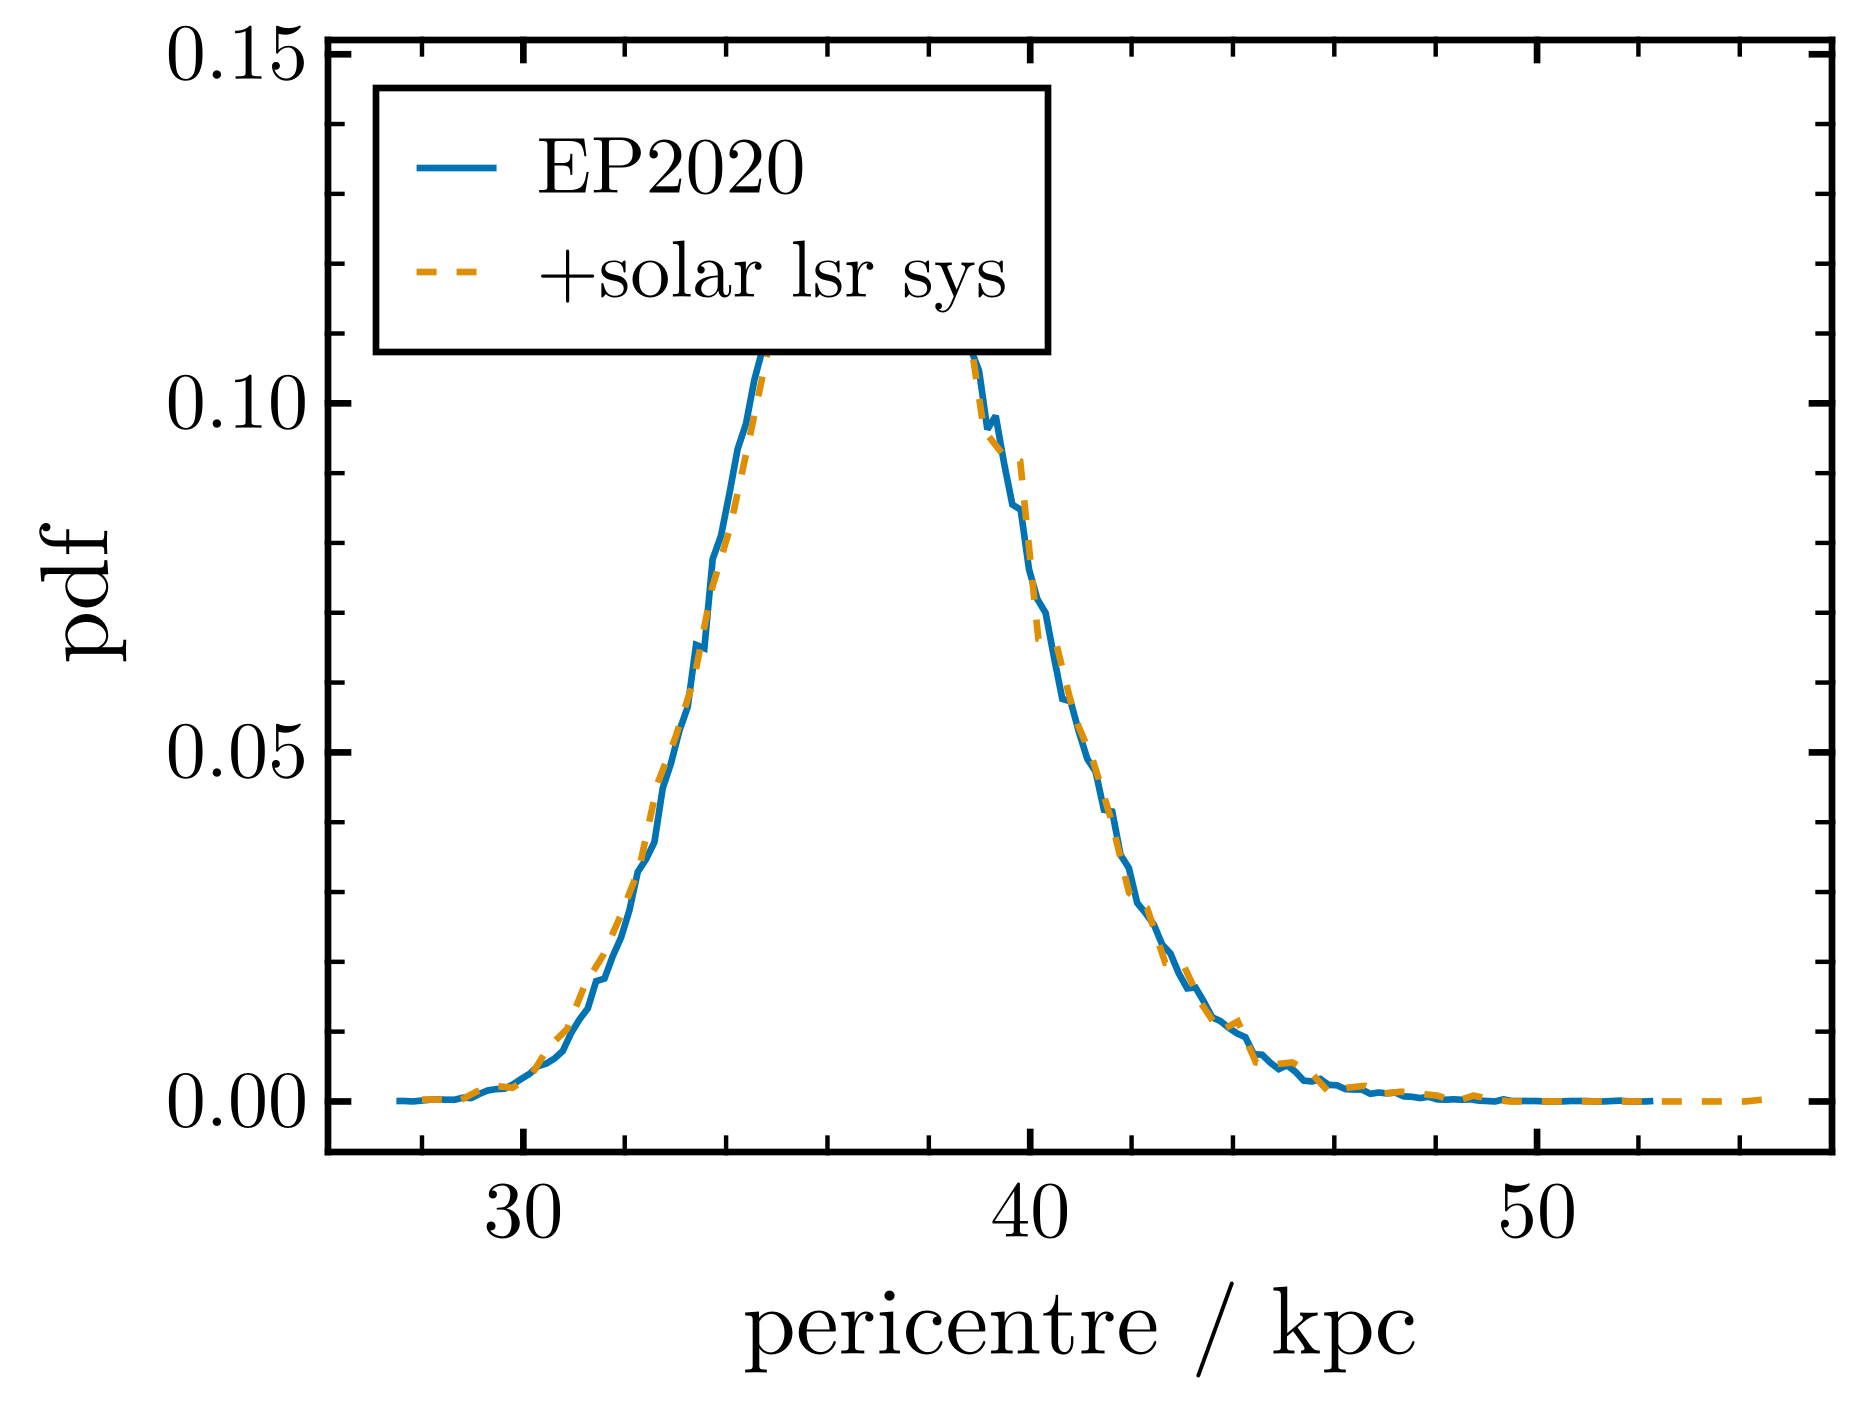

In [33]:
compare_peris(families)

[ Info: Using default bins of size = 154
[ Info: Using default bins of size = 65


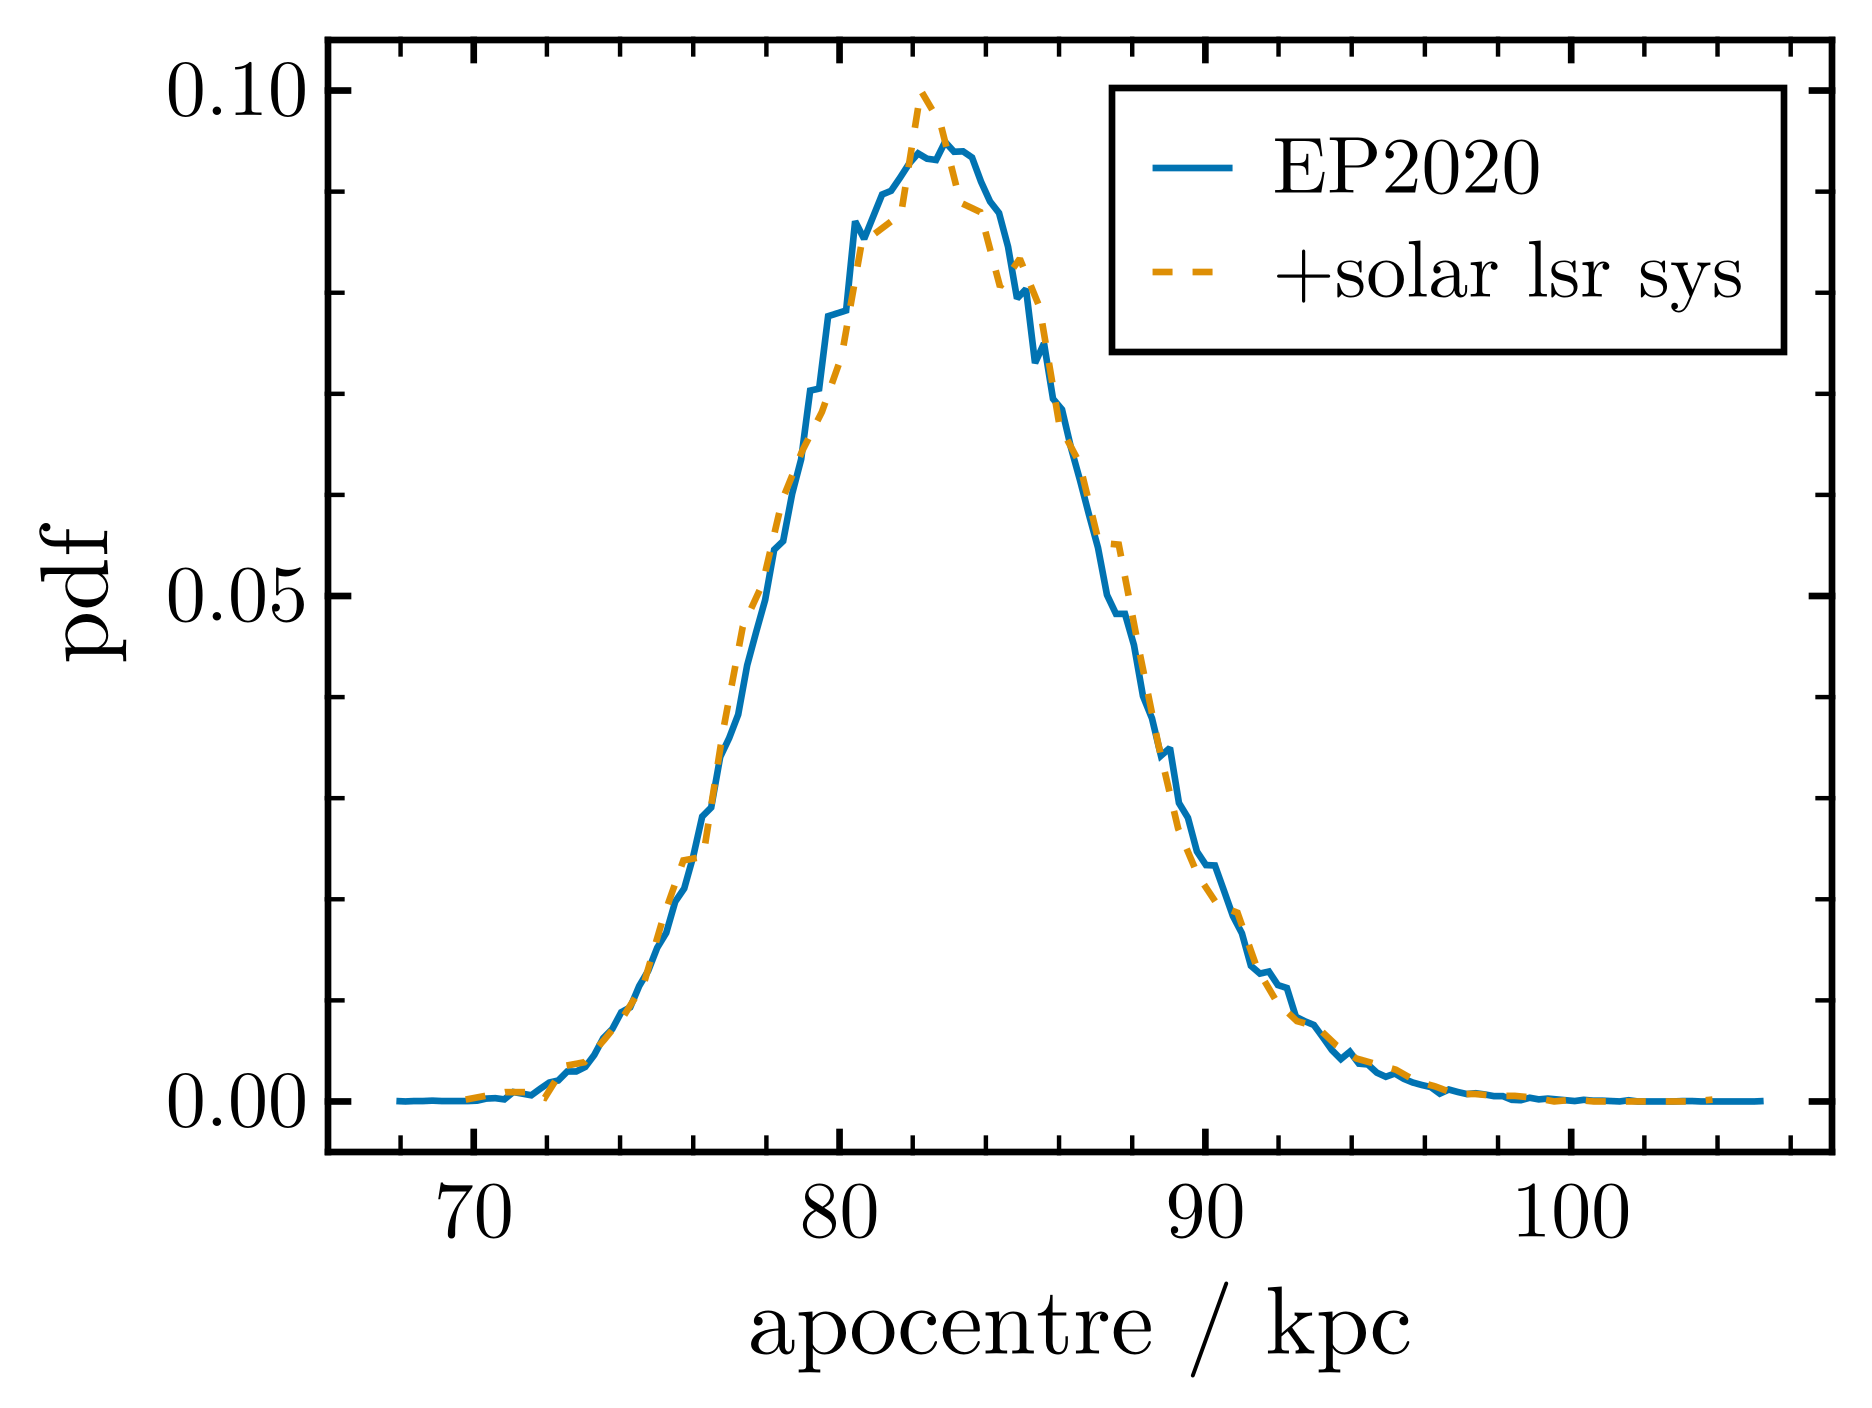

In [34]:
compare_apos(families)

## + trajectories

# LMC

## Trajectories

In [54]:
families = [
    "EP20 (MW only)" => read_distribution("EP2020"),
    #"V+21 (MW only)" => read_distribution("vasiliev+21_nolmc"),
    "V+21 (MW+LMC)" => read_distribution("vasiliev+21_lmc"),
    "V24 (MW only)" => read_distribution("vasiliev24_M11"),
    "V24 (MW+LMC)" => read_distribution("vasiliev24_L3M11"),
    ];

[ Info: astropy table opened
[ Info: astropy table opened
[ Info: astropy table opened
[ Info: astropy table opened


In [55]:
compare_stats(families)

pericentre
  EP20 (MW only)      37.000 [34.336 39.952] [[29.699 46.835]]
   V+21 (MW+LMC)      58.706 [53.864 64.471] [[46.083 76.390]]
   V24 (MW only)      43.105 [40.013 46.620] [[34.482 53.994]]
    V24 (MW+LMC)      45.608 [37.484 56.455] [[21.618 75.872]]
t last peri
  EP20 (MW only)       0.901 [0.005 1.027] [[0.005 1.212]]
   V+21 (MW+LMC)       2.461 [0.005 3.276] [[0.005 4.668]]
   V24 (MW only)       1.231 [0.005 1.439] [[0.005 1.745]]
    V24 (MW+LMC)       1.905 [0.005 2.385] [[0.005 3.197]]
peri lmc
   V+21 (MW+LMC)     117.733 [114.855 120.576] [[109.555 126.721]]
    V24 (MW+LMC)     116.056 [31.363 119.789] [[1.055 125.478]]
peri lmc time
   V+21 (MW+LMC)       0.005 [0.005 4.258] [[0.005 4.881]]
    V24 (MW+LMC)       2.964 [0.005 4.027] [[0.005 5.946]]


[ Info: Using default bins of size = 153
[ Info: Using default bins of size = 55
[ Info: Using default bins of size = 62
[ Info: Using default bins of size = 46
[ Info: Saving figure to pericentre_distributions_w_wo_lmc.pdf and ---.png in ./figures


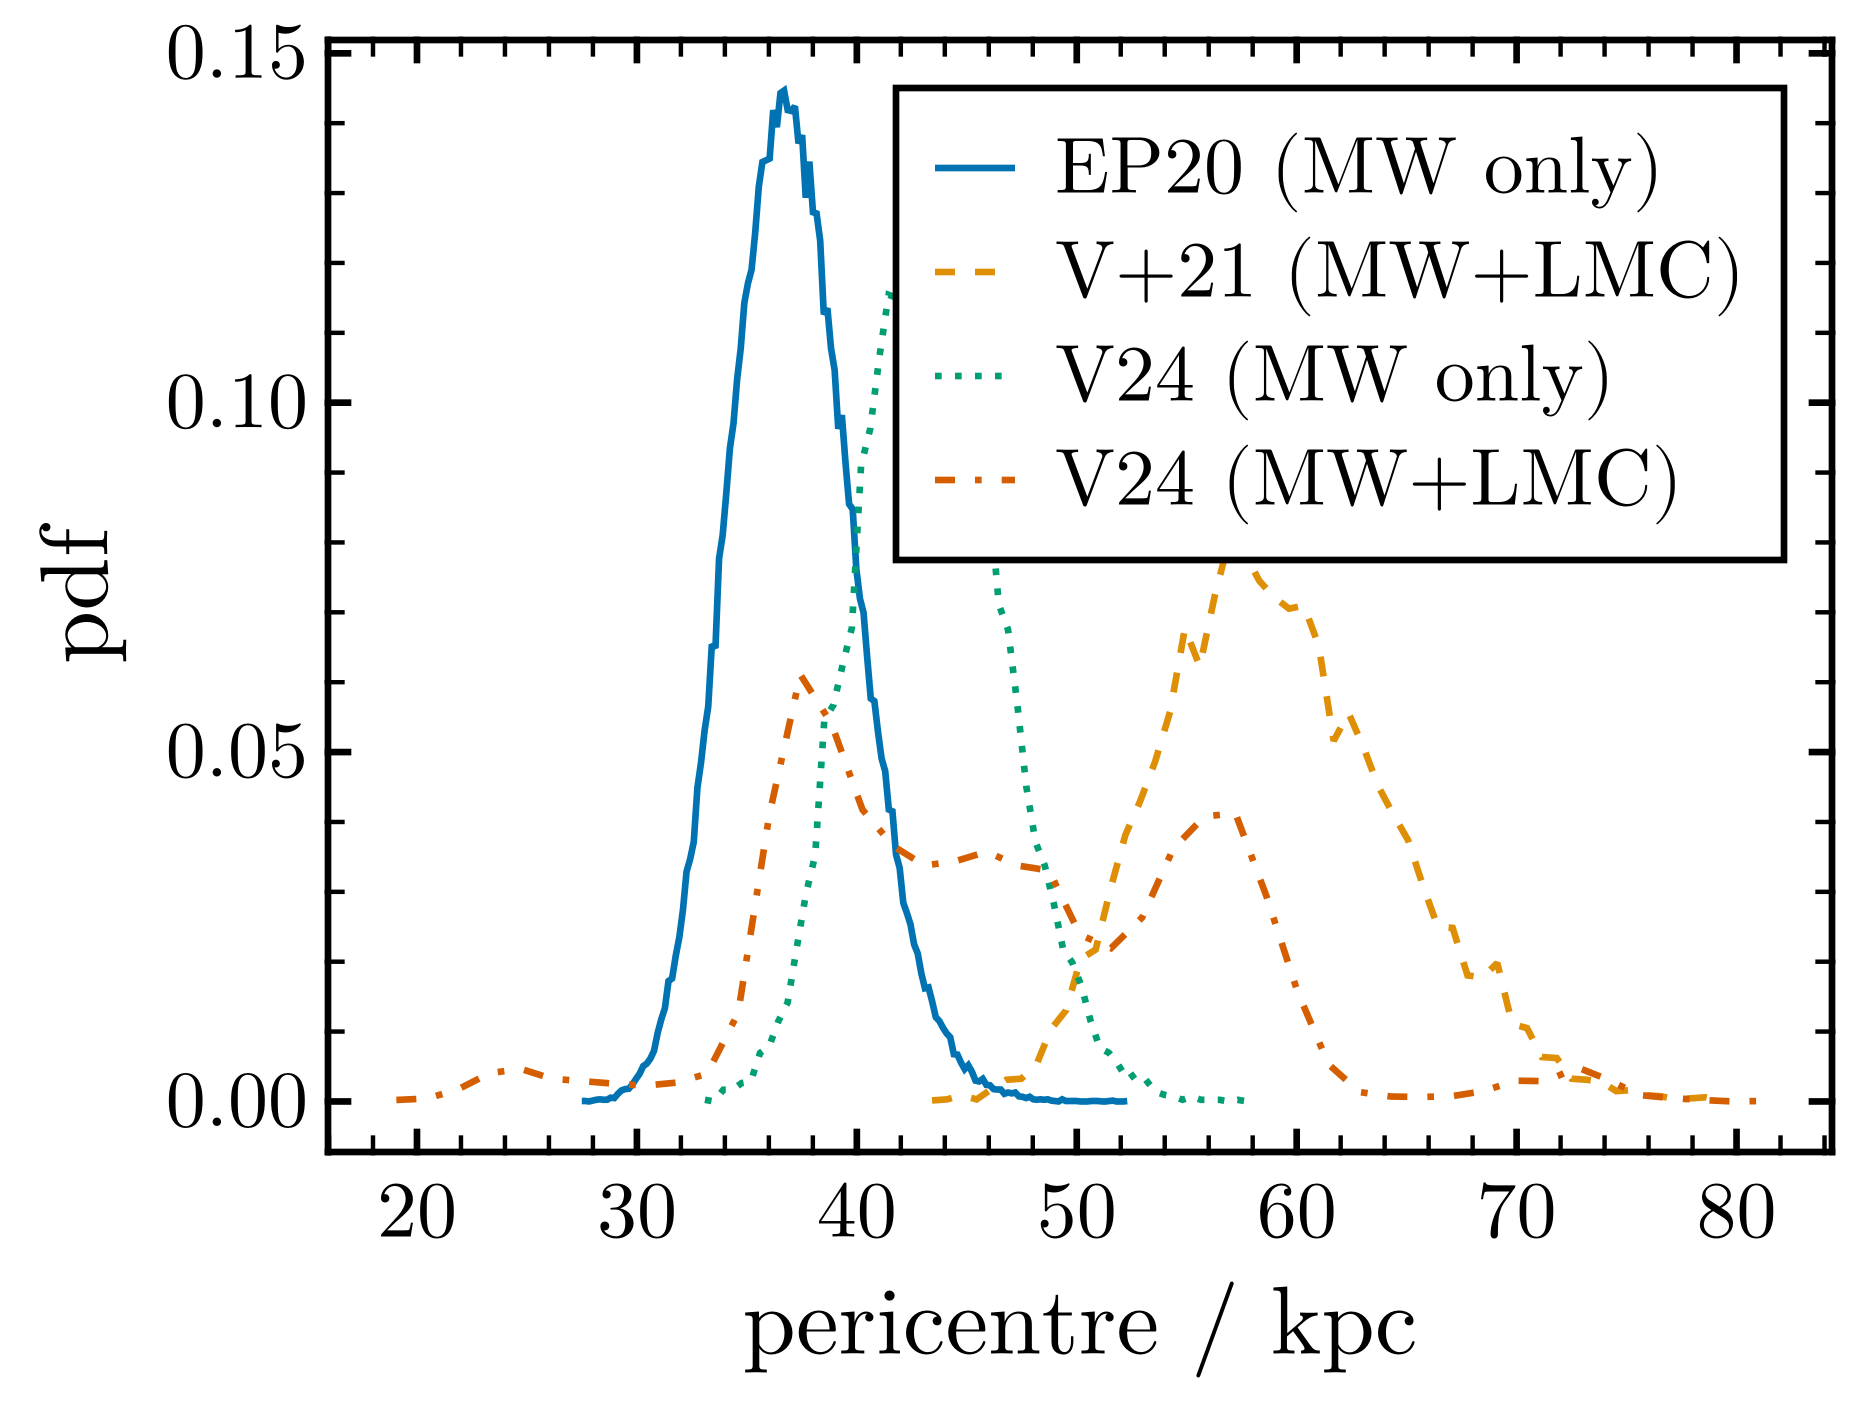

In [56]:
fig = compare_peris(families, legend_position=:rt)
@savefig "pericentre_distributions_w_wo_lmc"
fig

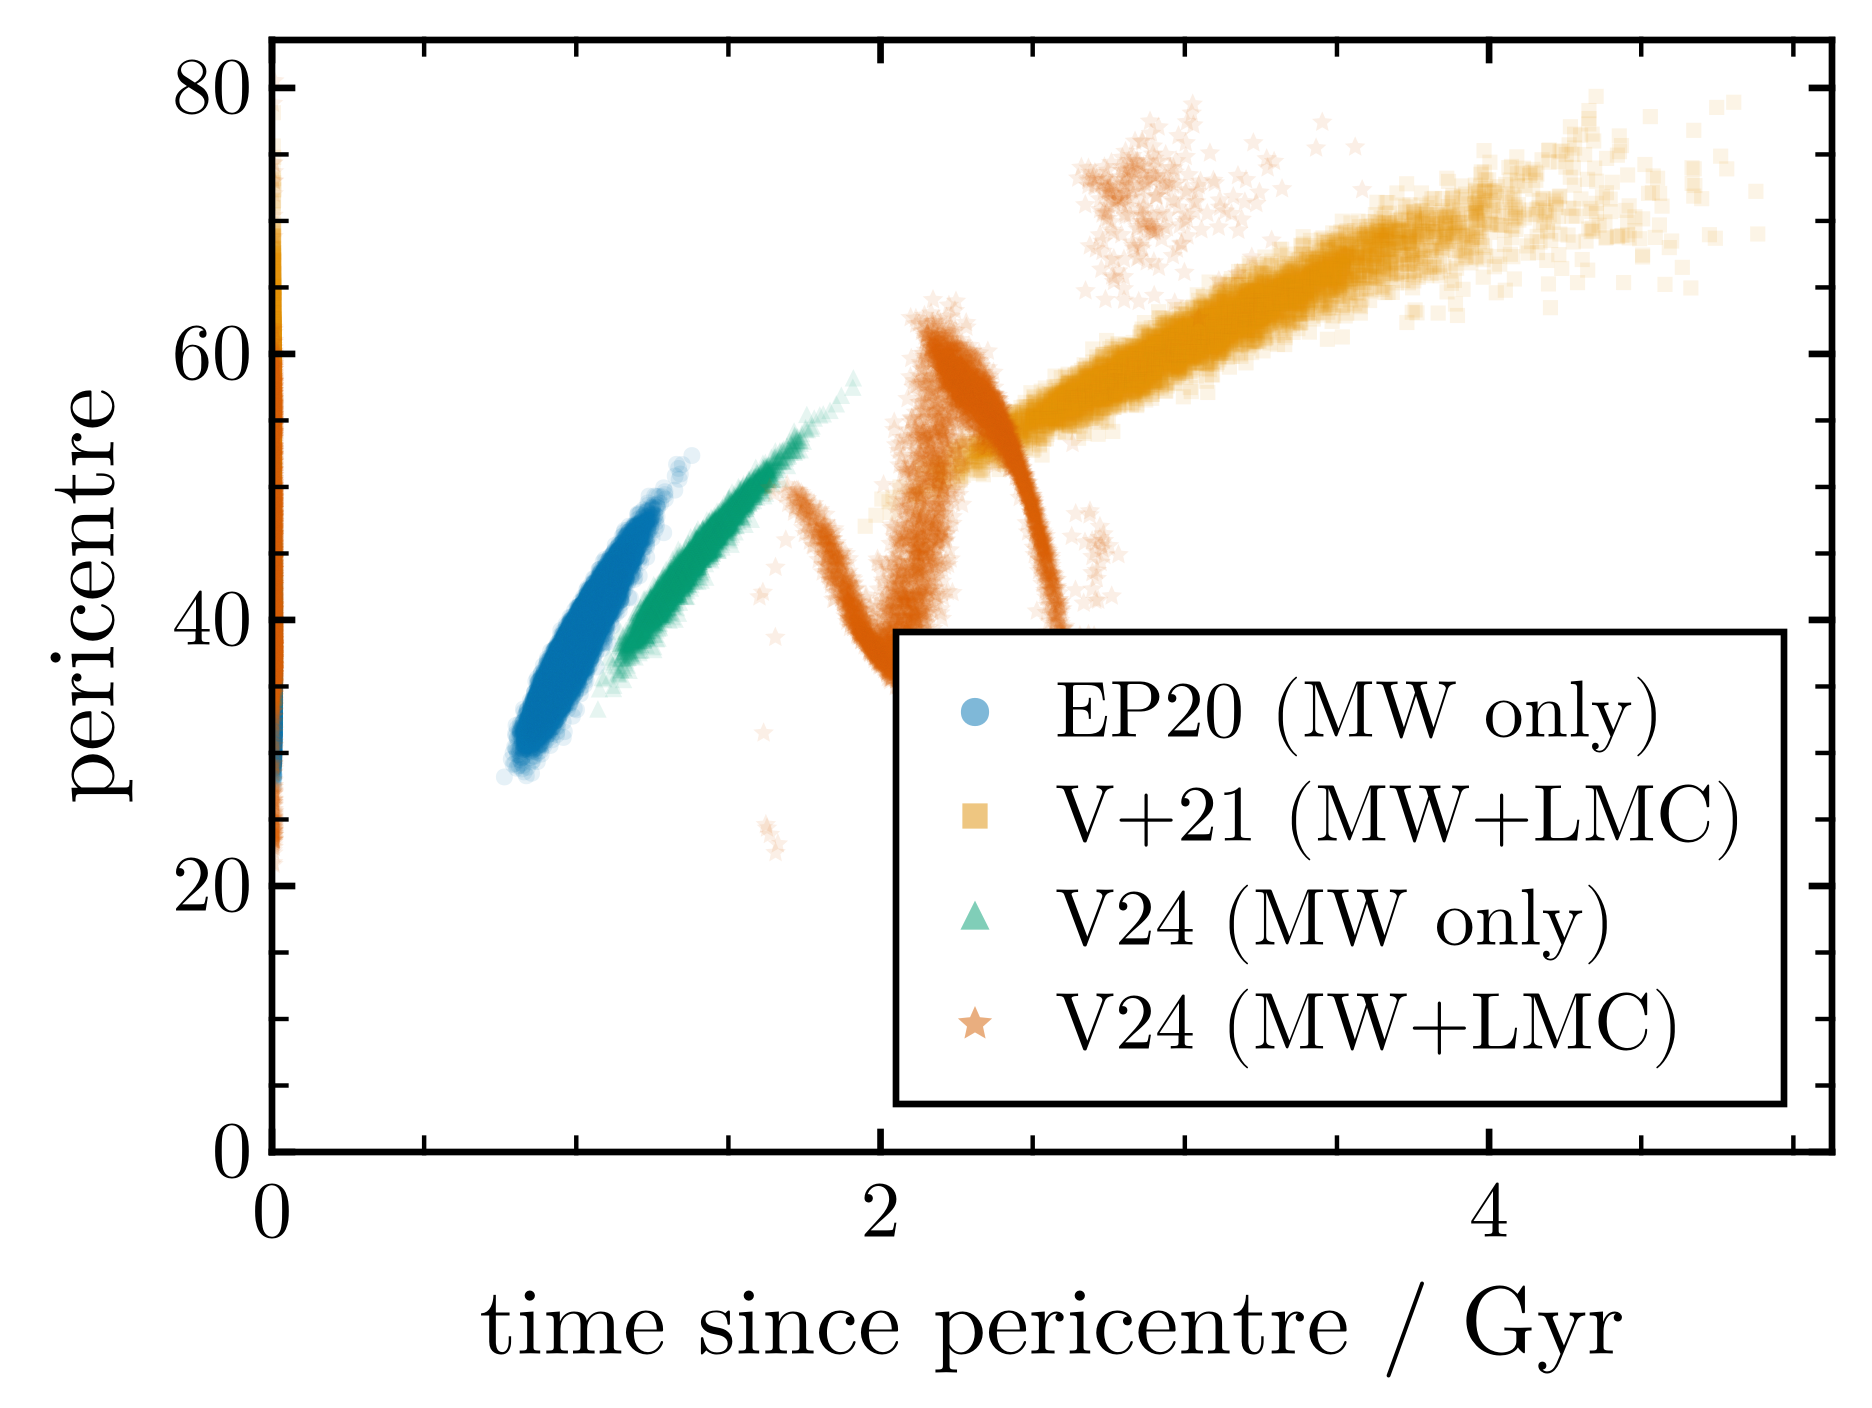

In [58]:
fig = Figure()
ax = Axis(fig[1, 1],
    xlabel = "time since pericentre / Gyr",
    ylabel = "pericentre",
    limits=(0, nothing, 0, nothing)
)

for (label, df) in families
    scatter!(df.t_last_peri*T2GYR .+ 0.2*T2GYR * randn(length(df.t_last_peri)), df.pericentre, 
        label=label => (; markersize=5, alpha=0.5), markersize=3, alpha=0.1)
end

axislegend(position=:rb)

fig

# Compare trajectories

In [59]:
traj = read_traj("vasiliev24_L3M11")

([-21.45441436767578 -22.941905975341797 … -21.207590103149414 -19.541597366333008; 50.30317687988281 55.92888259887695 … 49.37342834472656 43.09178161621094; 51.79141616821289 57.57659149169922 … 50.82966995239258 44.368812561035156;;; -21.487871170043945 -22.976228713989258 … -21.20533561706543 -19.619205474853516; 50.02314758300781 55.64515686035156 … 49.07597732543945 42.78795623779297; 52.57042694091797 58.35096740722656 … 51.64585876464844 45.15465545654297;;; -21.517967224121094 -23.007707595825195 … -21.199628829956055 -19.692527770996094; 49.73906326293945 55.358367919921875 … 48.77428436279297 42.47845458984375; 53.34348678588867 59.120384216308594 … 52.455909729003906 45.93290328979492;;; … ;;; -14.930148124694824 182.01052856445312 … 6.029189109802246 -15.661230087280273; 39.9748420715332 180.5174560546875 … -84.3144760131836 5.342371940612793; -115.68572998046875 -499.0526428222656 … -56.848960876464844 -42.774932861328125;;; -14.972184181213379 182.4344482421875 … 5.91552

In [60]:
traj_no = read_traj("vasiliev24_M11")

([-20.27882957458496 -21.112958908081055 … -20.04069709777832 -20.354326248168945; 45.879154205322266 49.03302764892578 … 44.98081588745117 46.1611442565918; 47.240516662597656 50.48324203491211 … 46.31671142578125 47.52878952026367;;; -20.337587356567383 -21.139474868774414 … -20.159822463989258 -20.476058959960938; 45.53661346435547 48.75638961791992 … 44.673824310302734 45.84160614013672; 48.08486557006836 51.259620666503906 … 47.09626388549805 48.320125579833984;;; -20.39291763305664 -21.162918090820312 … -20.275400161743164 -20.59438705444336; 45.1864013671875 48.4726676940918 … 44.358970642089844 45.51445007324219; 48.921104431152344 52.02853775024414 … 47.867515563964844 49.10342025756836;;; … ;;; -25.524572372436523 -3.498994827270508 … 18.875226974487305 8.477616310119629; 55.30995559692383 -10.855865478515625 … -1.155504584312439 -44.62236785888672; 64.52001190185547 48.05661392211914 … -79.94844055175781 0.3588014543056488;;; -25.430824279785156 -3.148799180984497 … 18.79246

In [61]:
V_T2GYR = 0.97779

0.97779

In [74]:
# loads in trajectory of lmc in Vasiliev 2021
lmc_file = ENV["DWARFS_ROOT"] * "/analysis/ursa_minor/mc_orbits/vasiliev24_L3M11/lmc_traj.csv"
df_lmc = (CSV.read(lmc_file, DataFrame))# [end:-1:1, :]

times_v = df_lmc.time
pos_lmc = reshape([df_lmc.x df_lmc.y df_lmc.z]', (3, 1, :))
vel_lmc = reshape([df_lmc.v_x df_lmc.v_y df_lmc.v_z]', (3, 1, :))

3×1×2121 reshape(adjoint(::Matrix{Float64}), 3, 1, 2121) with eltype Float64:
[:, :, 1] =
 -0.33764971070395366
 -1.050523818707811
  1.0432570395371263

[:, :, 2] =
 -0.33815478428562296
 -1.0698653796984596
  1.0322927377192084

[:, :, 3] =
 -0.33855110007958533
 -1.0890706384309001
  1.0208344976314

;;; … 

[:, :, 2119] =
 -0.11957029893924782
 -0.4118351976856316
  0.32833534233365474

[:, :, 2120] =
 -0.11957029893924782
 -0.4118351976856316
  0.32833534233365474

[:, :, 2121] =
 -0.11957029893924782
 -0.4118351976856316
  0.32833534233365474

In [75]:
traj_lmc = pos_lmc, vel_lmc, -df_lmc.time
traj_scl_lmc = pos_lmc .- traj[1], vel_lmc .- traj[2], traj[3]


([20.639344367675783 22.1268359753418 … 20.392520103149415 18.72652736633301; -92.24383687988282 -97.86954259887696 … -91.31408834472657 -85.03244161621095; -77.6513361682129 -83.43651149169922 … -76.68958995239258 -70.22873256103516;;; 21.0227995900779 22.51115713402321 … 20.740264037099383 19.15413389488747; -90.86053210923532 -96.48254138657907 … -89.91336185166696 -83.62534076402048; -79.50166323148139 -85.28220369778998 … -78.57709505521186 -72.08589174710639;;; 21.403163584689313 22.892903956393415 … 21.084825190524274 19.577724131564313; -89.45964905482728 -95.0789537118097 … -88.4948701546808 -82.19904038173158; -81.33791485214012 -87.11481228256004 … -80.45033779525535 -73.92733135604637;;; … ;;; 127.14612812469483 -69.79454856445312 … 106.18679089019776 127.87721008728028; 83.69884792846679 -56.84376605468751 … 207.9881660131836 118.3313180593872; -388.49663001953127 -5.129717177734392 … -447.3333991235352 -461.4074271386719;;; 127.18816418121338 -70.2184682421875 … 106.30045

In [76]:
ii = argmax(traj[1][1, :, end])

509

In [77]:
traj_scl_lmc[1][:, ii, [1,end]]

3×2 Matrix{Float64}:
  20.3145  -76.8469
 -91.0103  -56.6332
 -76.3781  -11.6523

In [78]:
traj[1][:, ii, [1, end]]

3×2 Matrix{Float64}:
 -21.1296   189.063
  49.0696   180.307
  50.5182  -492.53

In [79]:
traj_lmc[1][:, 1, [1, end]]

3×2 Matrix{Float64}:
  -0.81507   112.216
 -41.9407    123.674
 -25.8599   -504.182

In [86]:
function plot_r_t_traj!(traj; alpha=0.01, thin=1, color=:black, kwargs...)
    positions, velocities, times = traj
    for i in 1:thin:size(positions, 2)
        x = times * T2GYR
        y = radii(positions[:, i, :])
        lines!(x, y; rasterize=true, alpha=alpha, color=color, kwargs...)
    
    end
end

plot_r_t_traj! (generic function with 1 method)

In [81]:
function plot_x_y_traj!(traj; thin=1, x_direction=2, y_direction=3, alpha=0.01, color=:black, kwargs...)
    positions, velocities, times = traj
    for i in 1:thin:size(positions, 2)
        x = positions[x_direction, i, :]
        y = positions[y_direction, i, :]
        
        lines!(x, y; rasterize=true, alpha=alpha, color=color, kwargs...)
    
    end
end

plot_x_y_traj! (generic function with 1 method)

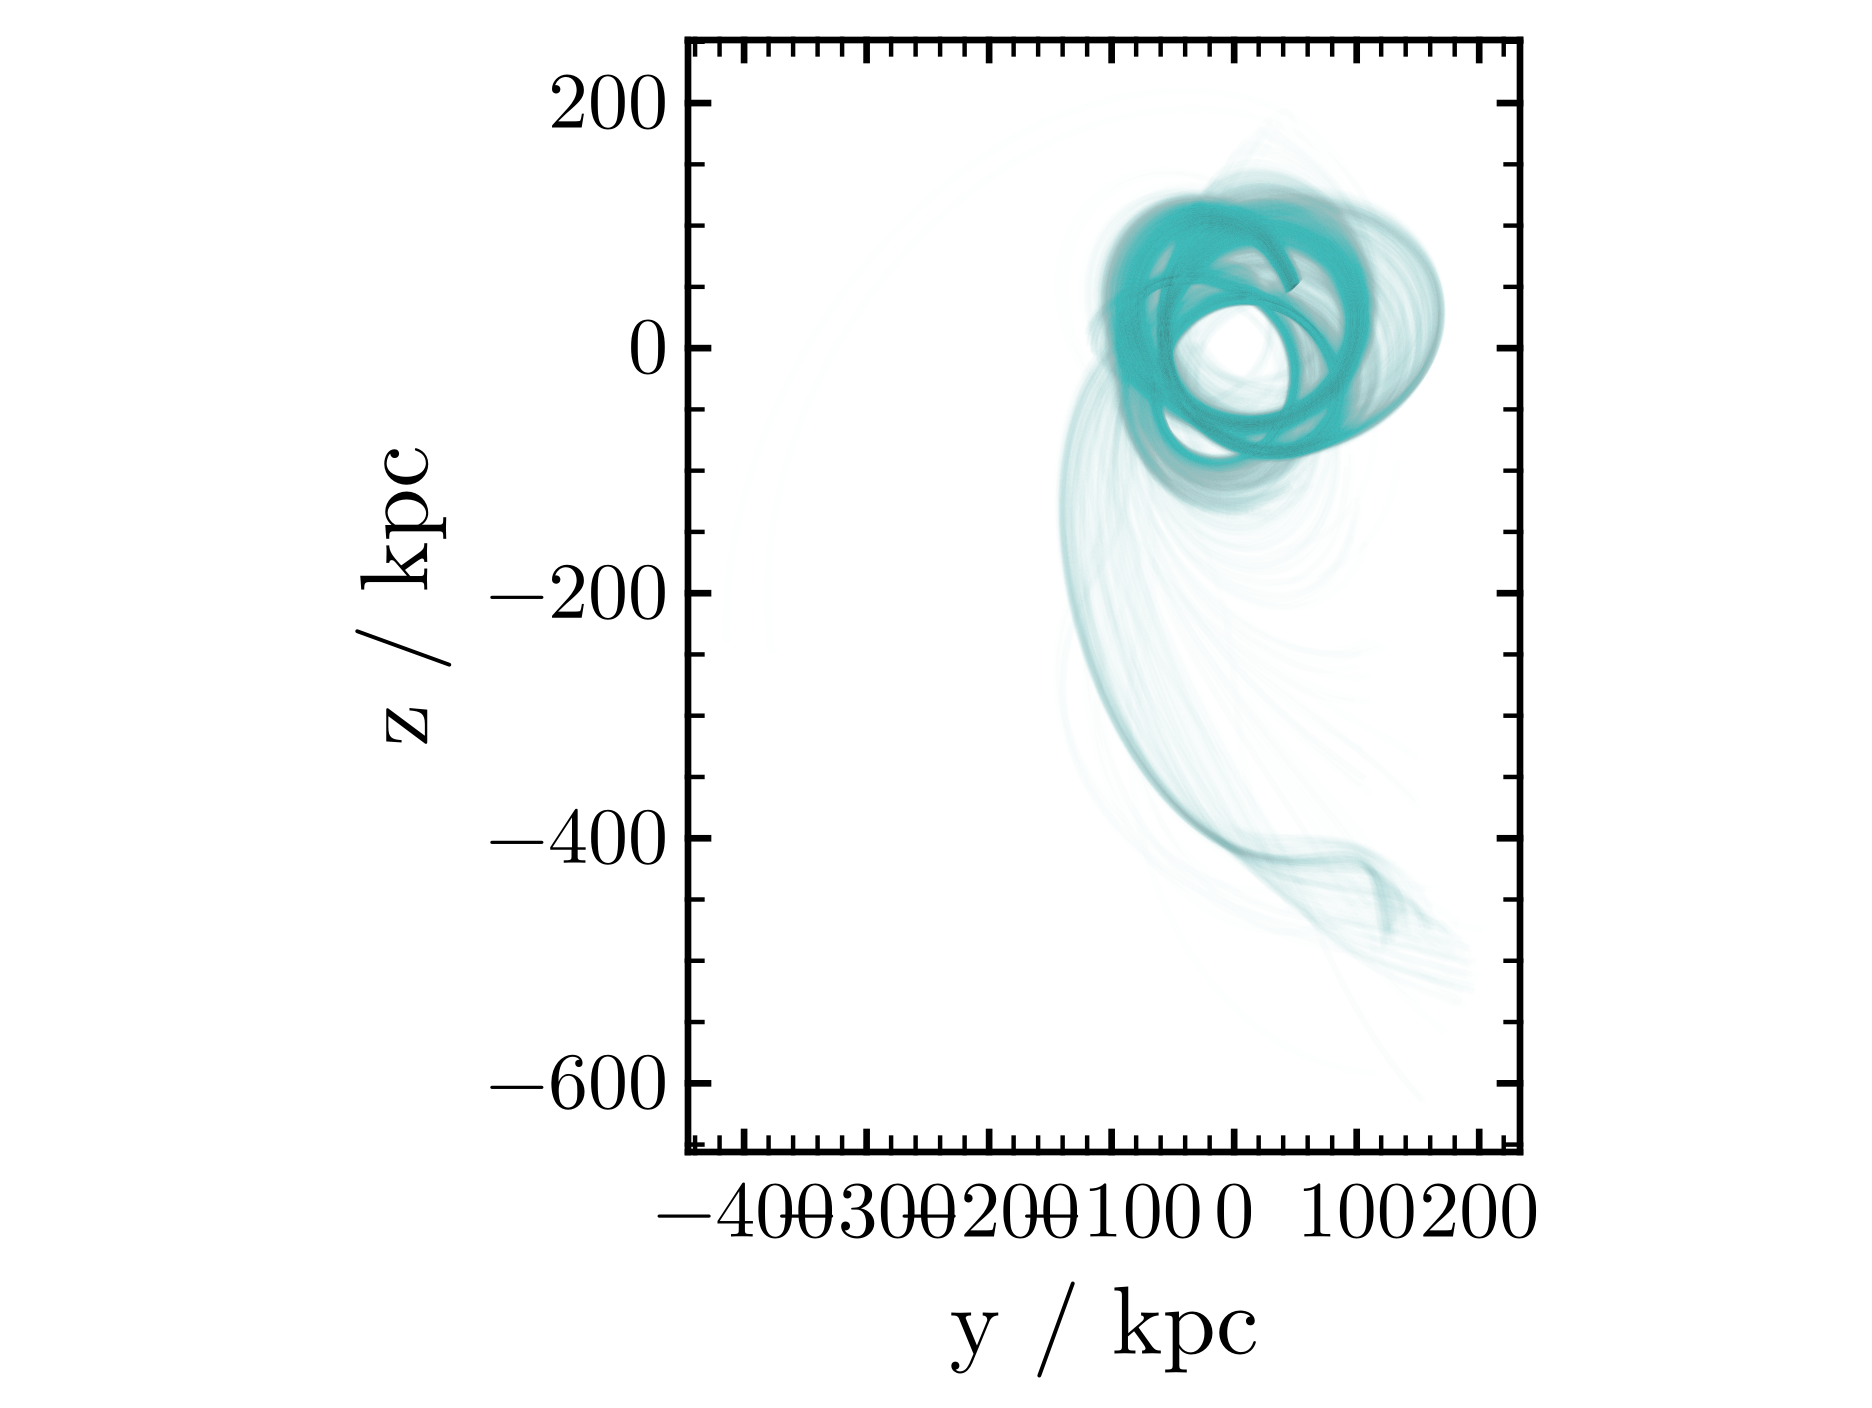

In [92]:
compare_x_y_traj(["" => traj])[1]

In [82]:
function compare_x_y_traj(trajectories; kwargs...)
    fig = Figure()
    ax = Axis(fig[1, 1], xlabel="y / kpc", ylabel="z / kpc",
        xgridvisible=false, ygridvisible=false, 
        aspect=DataAspect(),
    )
    
    for (i, (label, traj)) in enumerate(trajectories)
        plot_x_y_traj!(traj, label=label, color=COLORS[i]; kwargs...)
    end
        
    fig, ax
end

compare_x_y_traj (generic function with 1 method)

In [83]:
function compare_r_t_traj(trajectories; kwargs...)
    fig = Figure()
    ax = Axis(fig[1, 1], xlabel="time / Gyr", ylabel = "Scl galactocentric distance / kpc",
        xgridvisible=false, ygridvisible=false
    )

    for (i, (label, traj)) in enumerate(trajectories)
        plot_r_t_traj!(traj, label=label, color=COLORS[i]; kwargs...)
    end
    
    fig, ax
end

compare_r_t_traj (generic function with 1 method)

In [84]:
r2 = @. traj_scl_lmc[1][1, :, :]^2 + traj_scl_lmc[1][2, :, :]^2 + traj_scl_lmc[1][3, :, :]^2
r = sqrt.(r2)
idx_min = [argmin(row) for row in eachrow(r)]
t_scl_lmc_peri = traj_scl_lmc[3][idx_min]
r_scl_lmc_peri = [r[i, idx_min[i]] for i in 1:size(r, 1)]

1000-element Vector{Float64}:
 122.33003714116475
  12.012808723029789
  26.68271006777405
 119.076729902643
 121.75328805904213
  94.35762138486855
  22.361381113865292
 124.6027046184598
 121.30893332244888
 122.58069572056849
 119.94096041544795
 122.40943685036564
 124.40732615948384
   ⋮
 116.68366969520189
 117.55436640918356
 122.76409931242941
  67.54274734474586
 118.65789395804995
 123.97017137541103
  18.05739149607728
  93.4999671673922
 118.07963120208179
  24.466406341131677
 120.97690198319675
  35.5007516790077

[ Info: Saving figure to r_t_w_wo_lmc.pdf and ---.png in ./figures


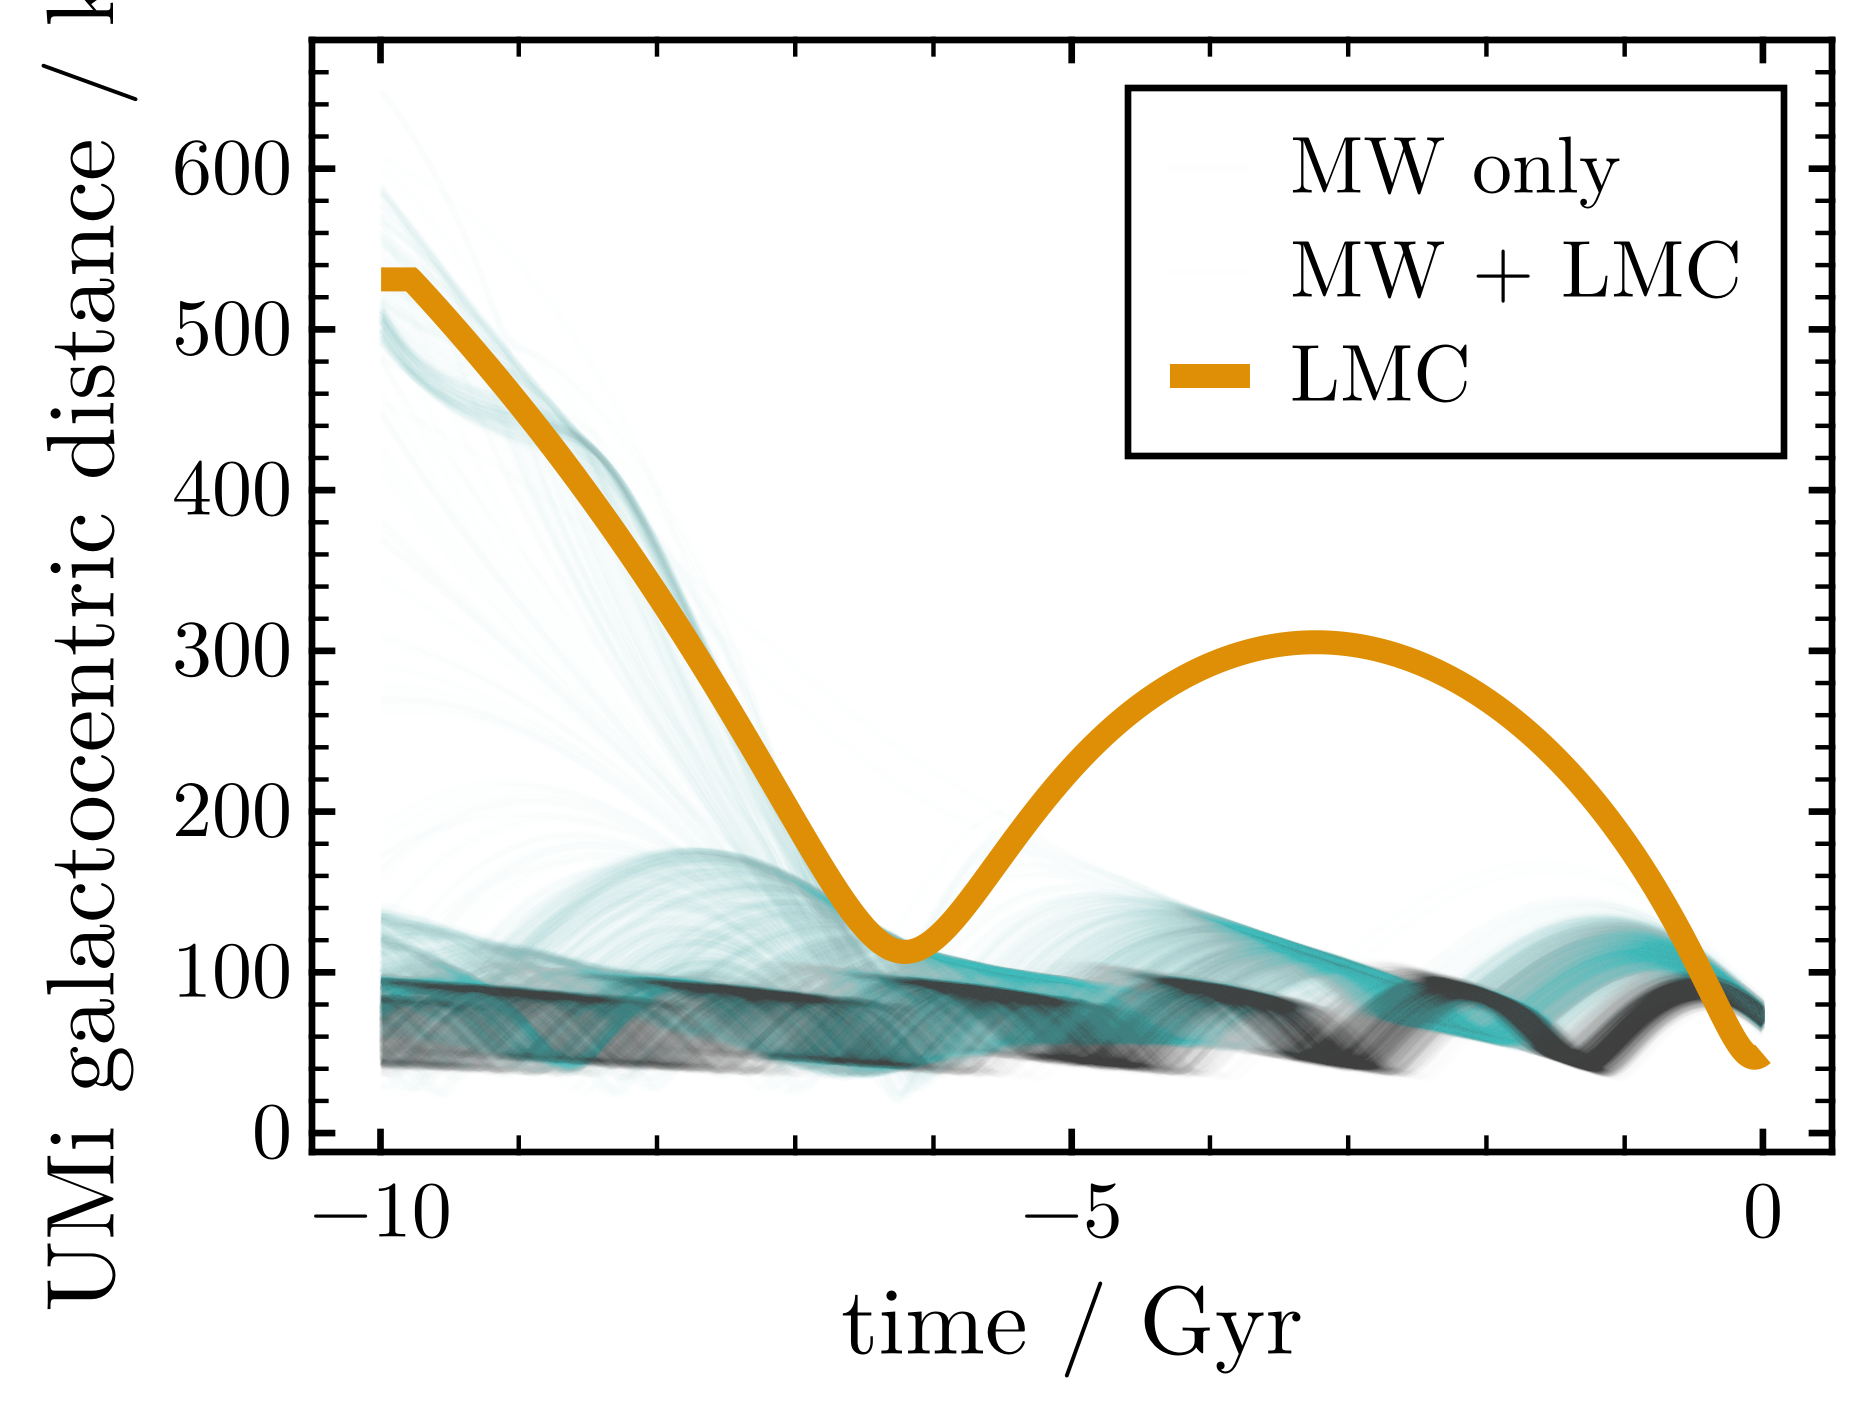

In [88]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="time / Gyr", ylabel = "UMi galactocentric distance / kpc",
    xgridvisible=false, ygridvisible=false
)

plot_r_t_traj!(traj_no, label="MW only")
plot_r_t_traj!(traj, label="MW + LMC", color=COLORS[1])
plot_r_t_traj!(traj_lmc, label="LMC", alpha=1, color=COLORS[2], linewidth=3)

axislegend(unique=true)
@savefig "r_t_w_wo_lmc"
fig

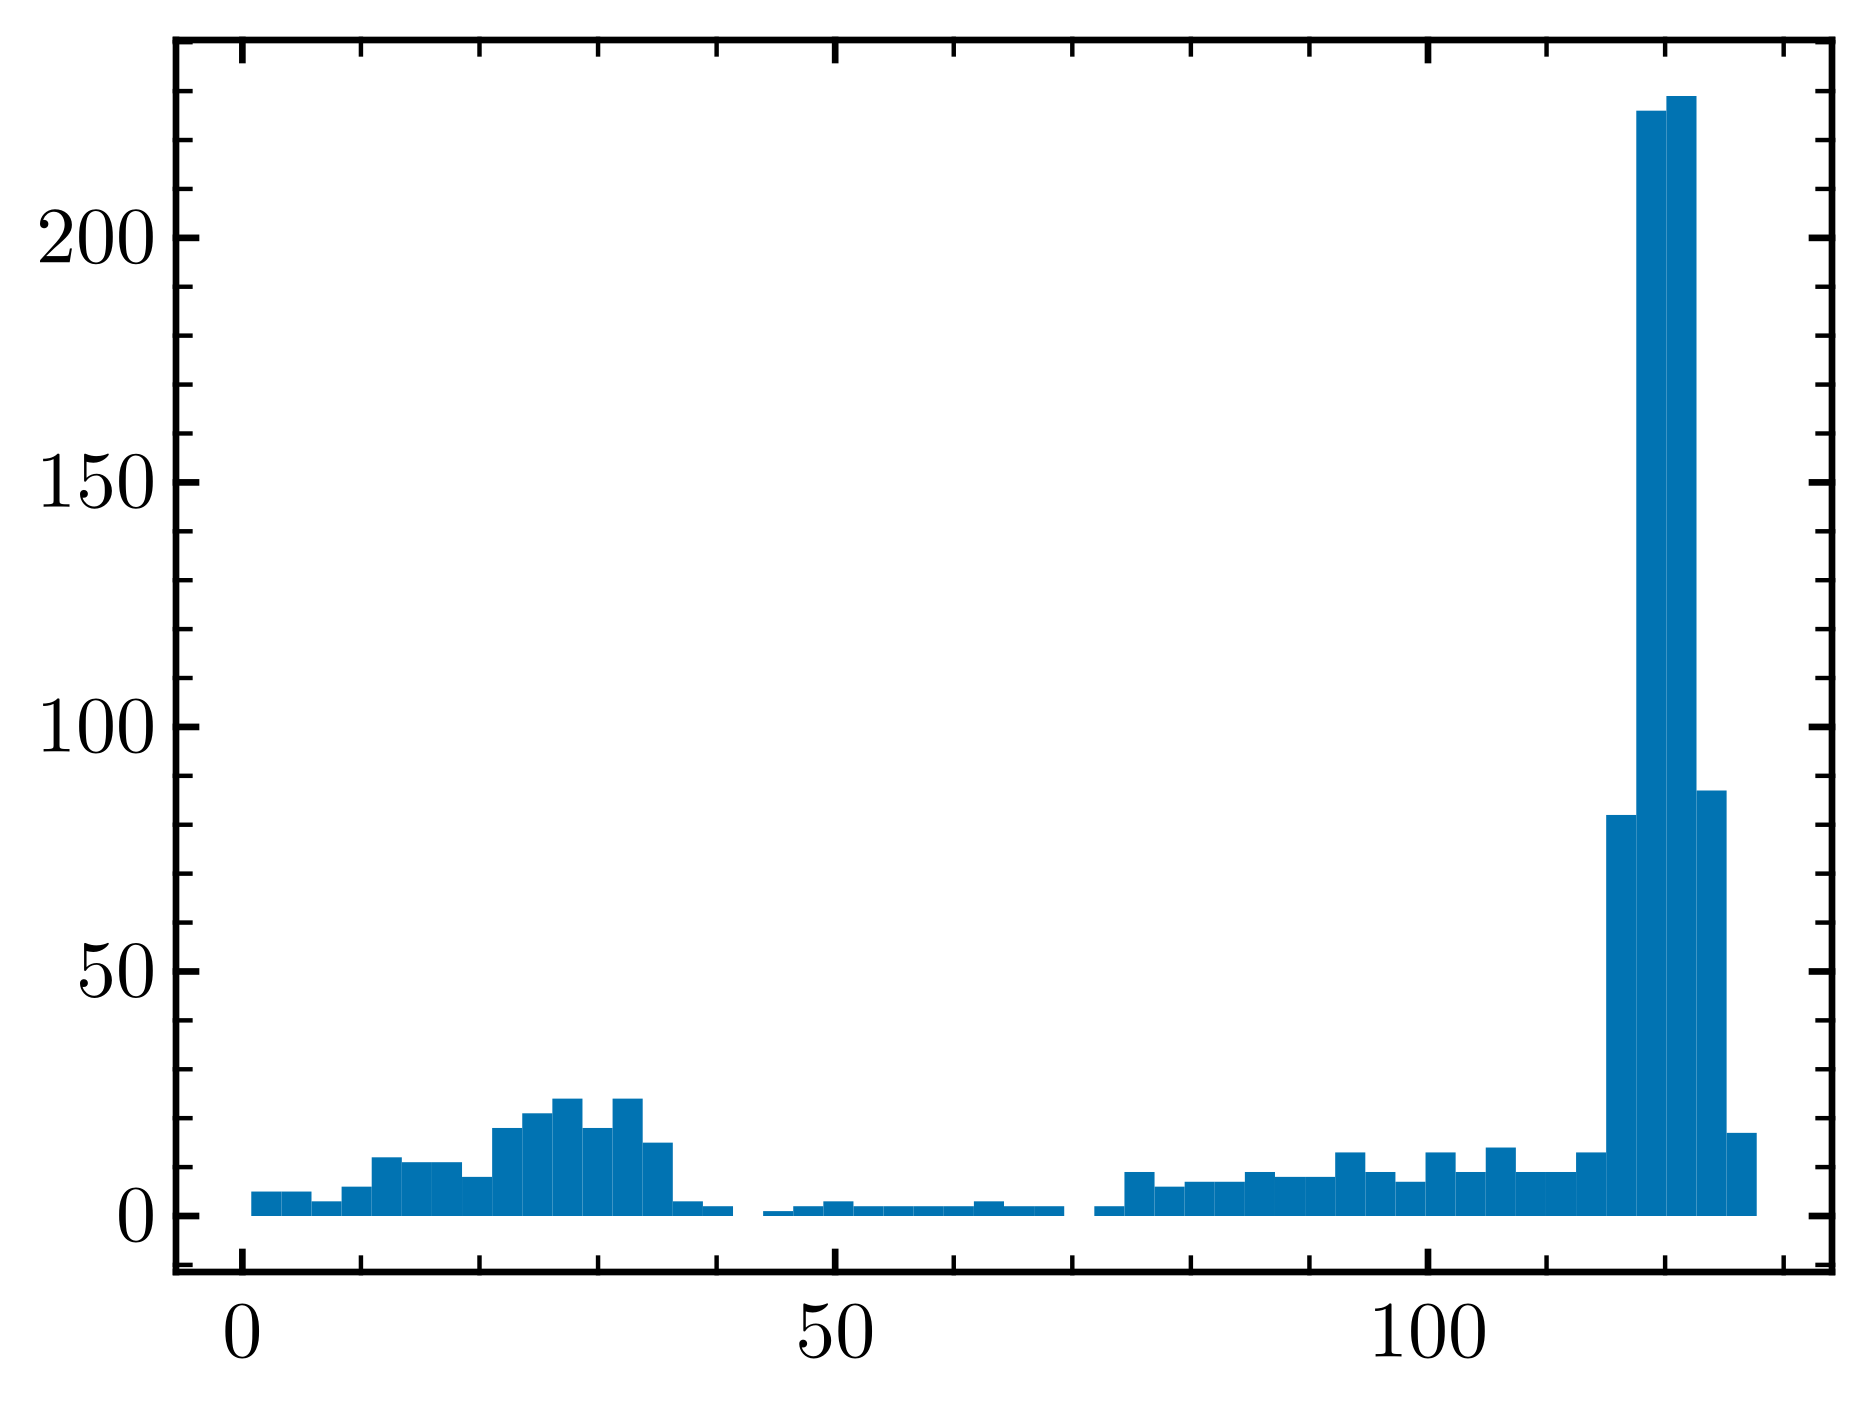

In [102]:
hist(r_scl_lmc_peri, bins=50)

In [104]:
mean(r_scl_lmc_peri .< 8)

0.013

In [96]:
pos_new = traj[1][:, r_scl_lmc_peri .< 50, :]

3×191×2121 Array{Float64, 3}:
[:, :, 1] =
 -22.9419  -21.9874  -19.677   -21.2518  …  -20.0038  -20.4095  -19.5416
  55.9289   52.3217   43.6094   49.5546      44.8352   46.3627   43.0918
  57.5766   53.8676   44.8976   51.0227      46.1597   47.7354   44.3688

[:, :, 2] =
 -22.9762  -21.9745  -19.7506  -21.289   …  -20.1041  -20.4961  -19.6192
  55.6452   52.0202   43.2994   49.2132      44.5342   46.08     42.788
  58.351    54.6737   45.6901   51.8664      46.9523   48.5017   45.1547

[:, :, 3] =
 -23.0077  -21.9585  -19.8199  -21.3228  …  -20.2004  -20.5788  -19.6925
  55.3584   51.715    42.9839   48.8677      44.228    45.7924   42.4785
  59.1204   55.4743   46.4753   52.7041      47.7378   49.2612   45.9329

;;; … 

[:, :, 2119] =
  182.011   141.021   113.67    102.108  …   170.365   135.85   -15.6612
  180.517   148.153   149.764   161.046      192.807   161.215    5.34237
 -499.053  -489.116  -461.051  -441.498     -490.525  -474.701  -42.7749

[:, :, 2120] =
  182.434   141.

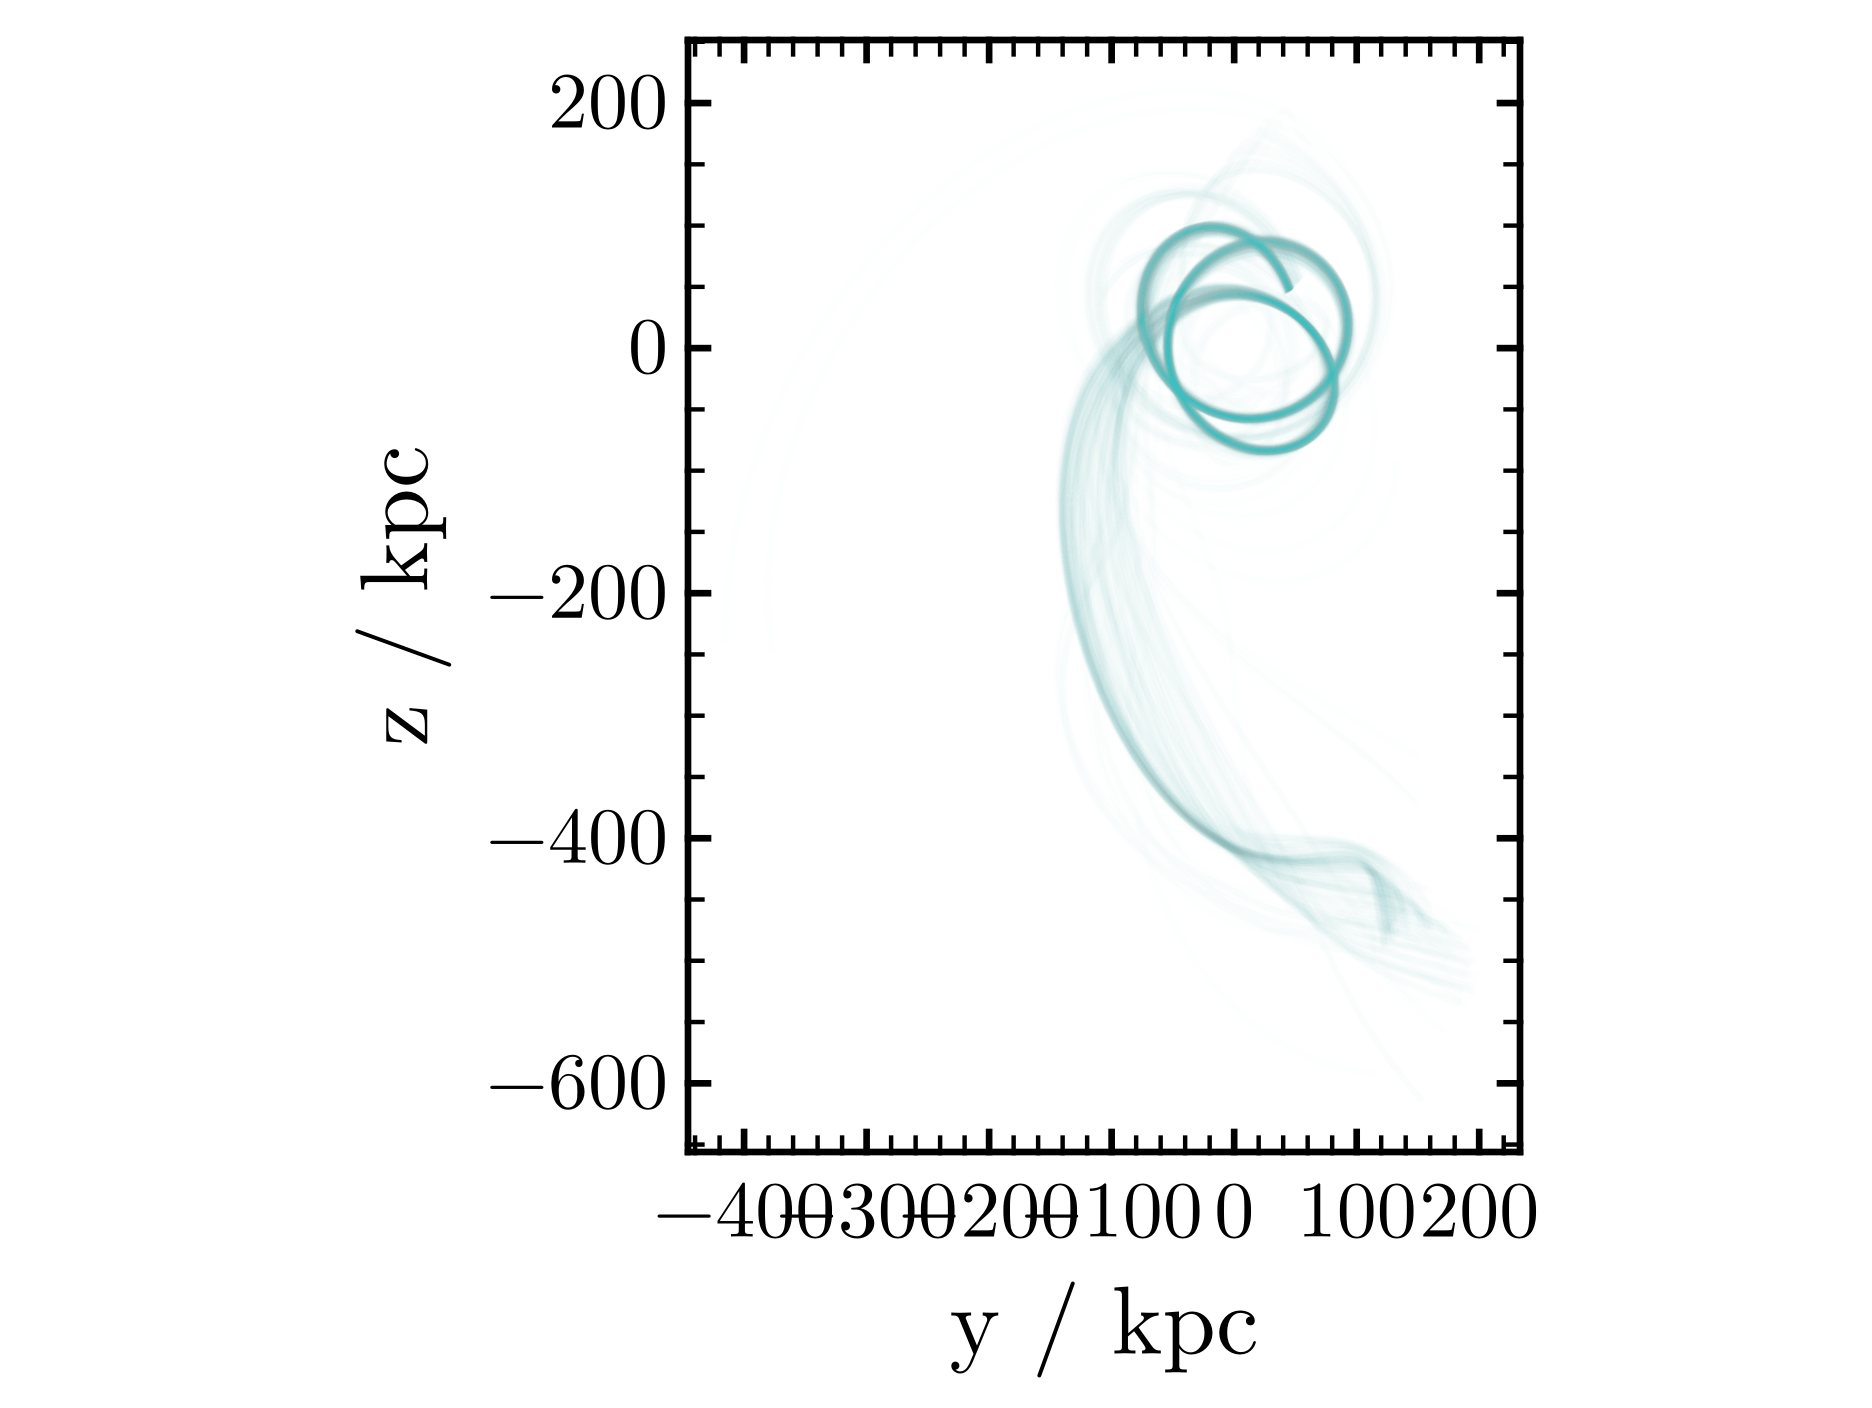

In [98]:
compare_x_y_traj(["" => [pos_new, traj[2], traj[3]]])[1]

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="time of minimum / Gyr", ylabel="minimum distance (Scl-LMC) / kpc")

scatter!(t_scl_lmc_peri * T2GYR .+ 0.0003 * randn(length(t_scl_lmc_peri)), r_scl_lmc_peri)
a
fig

The above plot shows that UMi does not become close at all to the LMC. The time of minimum distance is now.

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="time / Gyr", ylabel = "scl-lmc distance / kpc",
    xgridvisible=false, ygridvisible=false
)

plot_r_t_traj!(traj_scl_lmc)
save("$fig_dir/rt_lmc_frame.pdf")

fig

## 

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="y / kpc", ylabel="z / kpc",
    xgridvisible=false, ygridvisible=false, 
    aspect=DataAspect(),
)
plot_x_y_traj!(traj_scl_lmc)

save("$fig_dir/yz_lmc_frame.pdf")

fig

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="y / kpc", ylabel="z / kpc",
    xgridvisible=false, ygridvisible=false, 
    aspect=DataAspect(),
)
plot_x_y_traj!(traj_no, label="Umi, MW only")
plot_x_y_traj!(traj, label="Umi, MW + LMC", color=COLORS[1])
plot_x_y_traj!(traj_lmc, label="LMC", alpha=1, color=COLORS[2], linewidth=3)

Legend(fig[1,2], ax, unique=true)

save("$fig_dir/yz_umi_w_wo_lmc.pdf")
fig

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="x / kpc", ylabel="z / kpc",
    xgridvisible=false, ygridvisible=false, 
    aspect=DataAspect(),
)
plot_x_y_traj!(traj_no, label="Umi, MW only", x_direction=1)
plot_x_y_traj!(traj, label="Umi, MW + LMC", color=COLORS[1], x_direction=1)
plot_x_y_traj!(traj_lmc, label="LMC", alpha=1, color=COLORS[2], linewidth=3, x_direction=1)

Legend(fig[1,2], ax, unique=true)

fig

The predominant effect of adding an LMC to UMi's orbit is to increase the orbital radius. 
I believe this is because the LMC draws the MWs mass toward the other side of the galaxy, so UMi 
is less bound than it would be without the LMC.

### Other trajectories

In [89]:
traj_v21 = read_traj("vasiliev+21_lmc")

([-21.638080596923828 -20.51772117614746 … -20.026935577392578 -21.432598114013672; 51.00935363769531 46.78464889526367 … 44.92169189453125 50.219181060791016; 52.5140266418457 48.16935348510742 … 46.25442886352539 51.70513916015625;;; -21.676372528076172 -20.606185913085938 … -20.06639289855957 -21.476043701171875; 50.74647903442383 46.490577697753906 … 44.634090423583984 49.943565368652344; 53.272666931152344 48.95881652832031 … 47.02955627441406 52.46614074707031;;; -21.711681365966797 -20.69124412536621 … -20.10222625732422 -21.516433715820312; 50.480255126953125 46.19240951538086 … 44.34201431274414 49.66447067260742; 54.02650833129883 49.74267578125 … 47.798667907714844 53.22220230102539;;; … ;;; -29.685213088989258 -27.055662155151367 … 7.530693531036377 -28.185100555419922; 80.41156768798828 45.147056579589844 … -45.74353790283203 69.58092498779297; 117.438232421875 124.80989074707031 … 53.63272476196289 121.39374542236328;;; -29.632671356201172 -26.974306106567383 … 7.67089700

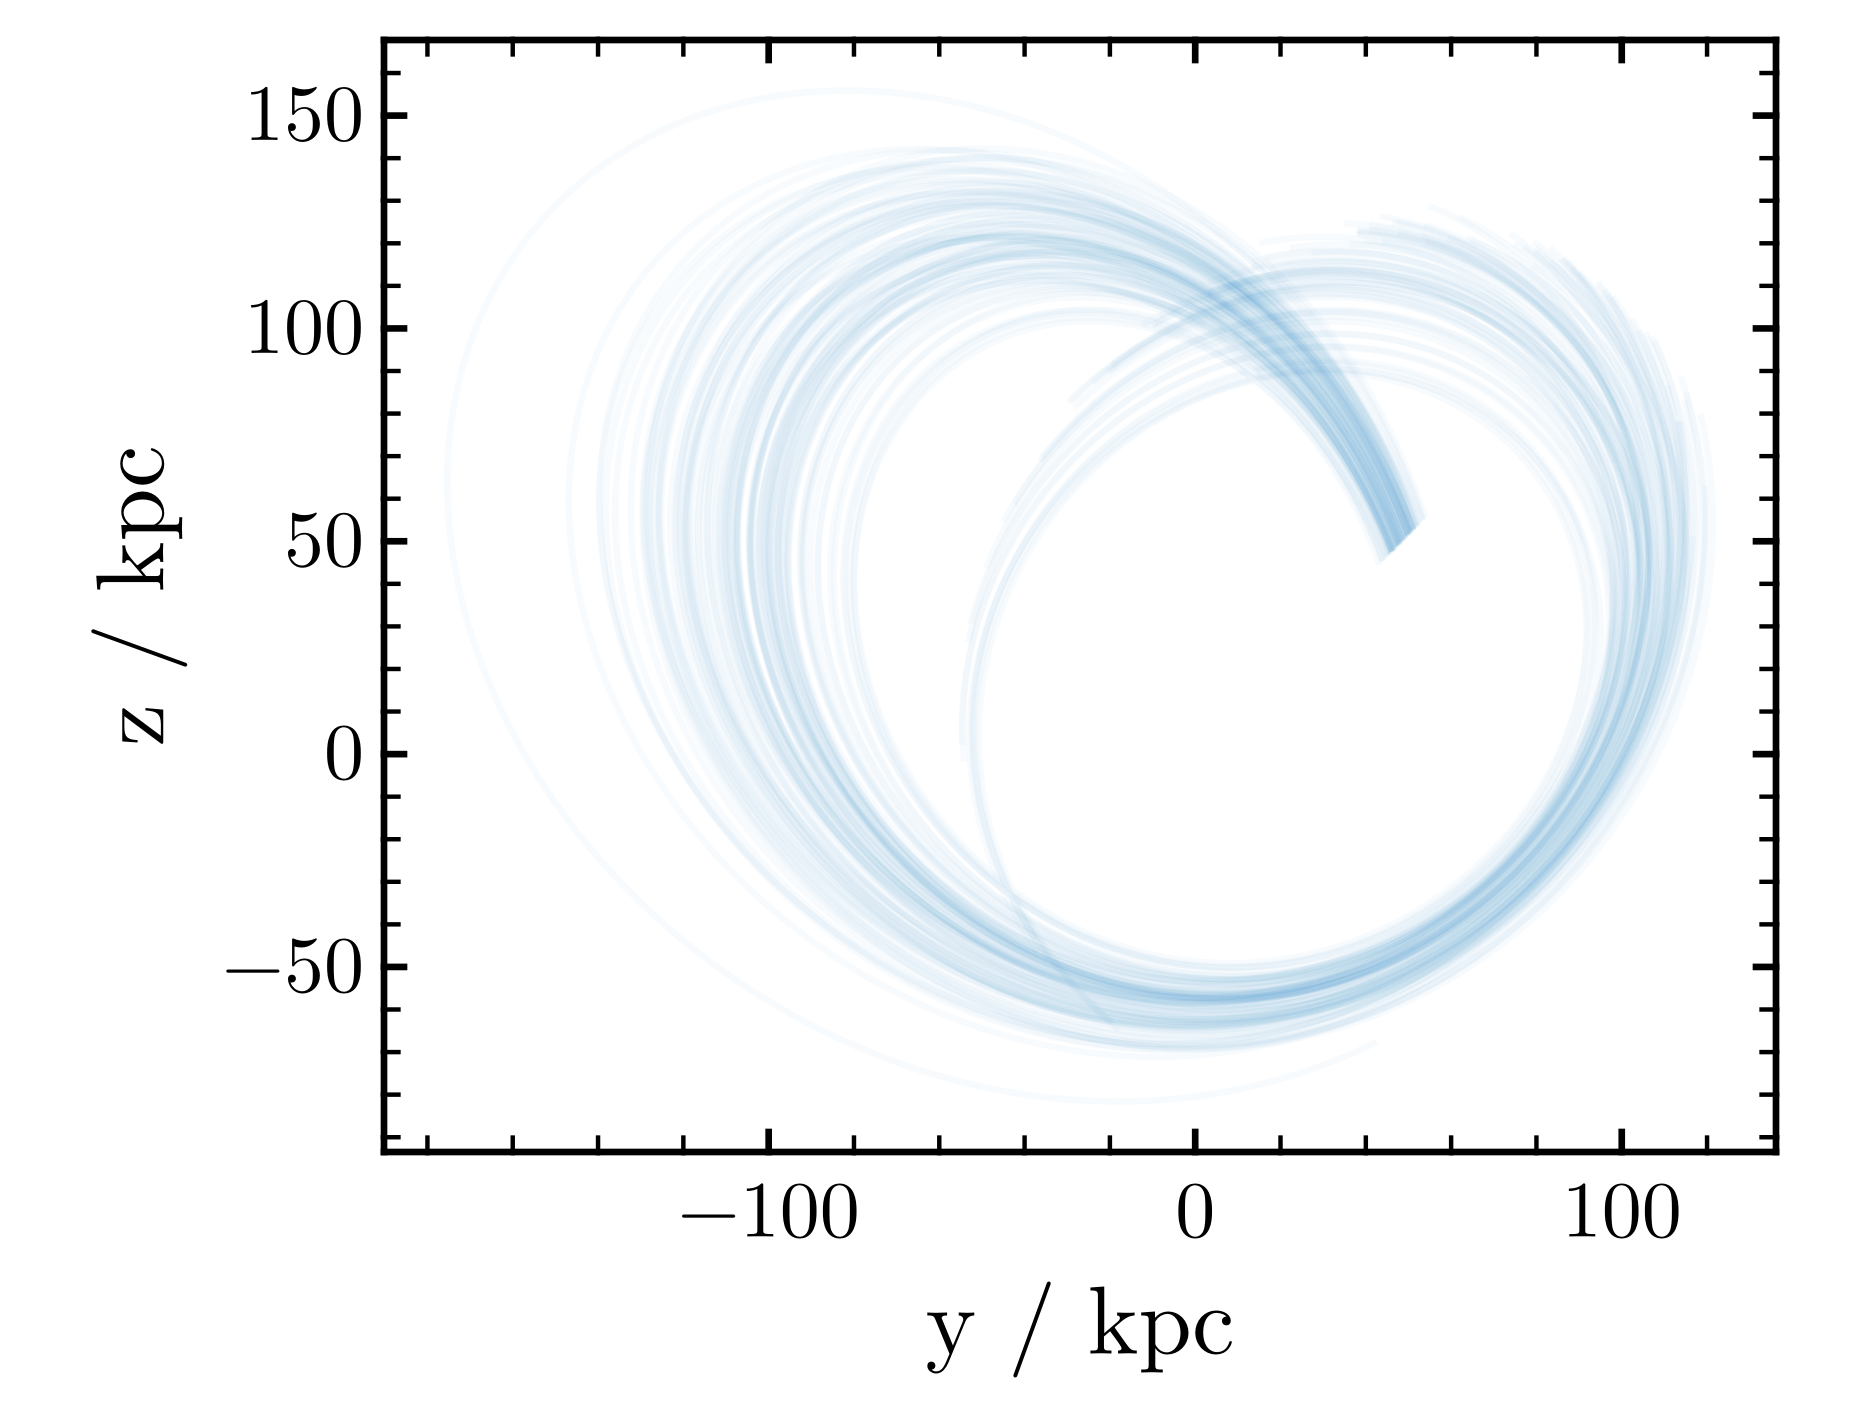

In [90]:
fig, ax = compare_x_y_traj([""=>traj_v21], thin=10, alpha=0.03)

# Legend(fig[1,2], ax, unique=true)
fig

In [ ]:
fig, ax = compare_x_y_traj(trajectories, x_direction=1, thin=10, alpha=0.03)

ax.xlabel = "x / kpc"
Legend(fig[1,2], ax, unique=true)
fig

In [ ]:
fig, ax = compare_x_y_traj(lmc_trajectories, alpha=1)
Legend(fig[1,2], ax, unique=true)
fig

In [ ]:
fig, ax = compare_x_y_traj(scl_lmc_trajectories, thin=10, alpha=0.03)

Legend(fig[1,2], ax, unique=true)
fig

In [ ]:
fig, ax = compare_r_t_traj(trajectories, thin=10, alpha=0.02)

Legend(fig[1,2], ax, unique=true)
fig

In [ ]:
fig, ax = compare_r_t_traj(lmc_trajectories, alpha=1)
ax.ylabel = "LMC - MW distance / kpc"
Legend(fig[1,2], ax, unique=true)
fig

In [ ]:
fig, ax = compare_r_t_traj(scl_lmc_trajectories, thin=10, alpha=0.02)

ax.ylabel = "Scl - LMC distance / kpc"
Legend(fig[1,2], ax, unique=true)
fig